In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
!pip install torch-summary
from torchsummary import summary
from torchvision.transforms import ToPILImage

In [2]:
# Define the transformations on the data
low_res_size = 128
high_res_size = 256

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

In [3]:
class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "low_res"))
        files_high = os.listdir(os.path.join(root_dir, "high_res"))
        self.data = list(zip(files_low, files_high))

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        # Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        # Apply the transformation to the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res, high_res

In [4]:
# Showing an image from the dataset
def show_image():
    dataset = ImageDataset(root_dir="/kaggle/input/test-2/dataset_new/train")
    loader = DataLoader(dataset, batch_size=128, num_workers=4)
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for idx, (low_res, high_res) in enumerate(loader):
        # Display the first image in the left subplot
        axs[0].imshow(low_res[0].permute(1, 2, 0))
        axs[0].set_title("low res")

        # Display the second image in the right subplot
        axs[1].imshow(high_res[0].permute(1, 2, 0))
        axs[1].set_title("high res")
        
        if(idx == 0):
            break
            
    # Show the figure
    plt.show() 

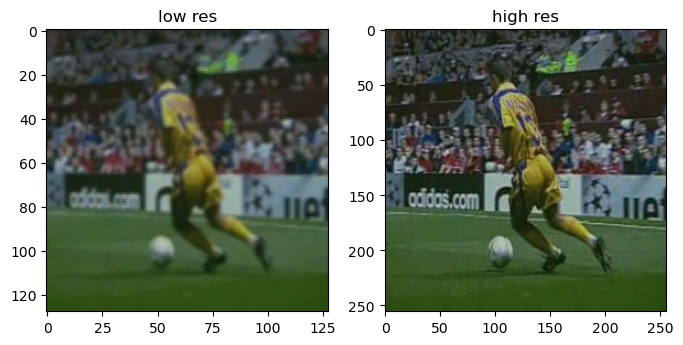

In [5]:
show_image()

#### define the hyperparameters

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
epochs = 12
batch_size = 10
num_workers = 2
img_channels = 3

In [7]:
# listing the model to take the required subset of it
test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
for idx, layer in enumerate(lf):
    print(f"Layer {idx}: {layer}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 90.4MB/s] 


Layer 0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 1: ReLU(inplace=True)
Layer 2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 3: ReLU(inplace=True)
Layer 4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 6: ReLU(inplace=True)
Layer 7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 8: ReLU(inplace=True)
Layer 9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 11: ReLU(inplace=True)
Layer 12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 13: ReLU(inplace=True)
Layer 14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 15: ReLU(inplace=True)
Layer 16: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 17: ReLU(inpl

In [8]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

In [9]:
class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):
        
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2
    
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [11]:
generator = Generator(in_channels=3, num_channels=64, num_blocks=16)
discriminator = Discriminator(in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512])

input_size = (3, 256, 256)

print("Generator Summary:")
summary(generator, input_size)

print("\nDiscriminator Summary:")
summary(discriminator, input_size)

Generator Summary:
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 64, 258, 258]        --
|    └─Conv2d: 2-1                       [-1, 64, 258, 258]        9,472
|    └─Identity: 2-2                     [-1, 64, 258, 258]        --
|    └─LeakyReLU: 2-3                    [-1, 64, 258, 258]        --
├─Sequential: 1-2                        [-1, 64, 258, 258]        --
|    └─ResidualBlock: 2-4                [-1, 64, 258, 258]        --
|    |    └─ConvBlock: 3-1               [-1, 64, 258, 258]        37,056
|    |    └─ConvBlock: 3-2               [-1, 64, 258, 258]        37,056
|    └─ResidualBlock: 2-5                [-1, 64, 258, 258]        --
|    |    └─ConvBlock: 3-3               [-1, 64, 258, 258]        37,056
|    |    └─ConvBlock: 3-4               [-1, 64, 258, 258]        37,056
|    └─ResidualBlock: 2-6                [-1, 64, 258, 258]        --
|    |    └─ConvBlock: 3-5               [-1, 6

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 16, 16]         --
|    └─ConvBlock: 2-1                    [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        1,792
|    |    └─Identity: 3-2                [-1, 64, 256, 256]        --
|    |    └─LeakyReLU: 3-3               [-1, 64, 256, 256]        --
|    └─ConvBlock: 2-2                    [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 128, 128]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 128, 128]        128
|    |    └─LeakyReLU: 3-6               [-1, 64, 128, 128]        --
|    └─ConvBlock: 2-3                    [-1, 128, 128, 128]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 128, 128]       73,856
|    |    └─BatchNorm2d: 3-8             [-1, 128, 128, 128]       256
|    |    └─LeakyReLU: 3-9               [-1, 128, 128, 128]       --
| 

In [12]:
def plot_examples(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input/test-2/dataset_new/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
        
            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")
        
            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")
        
            if(idx == 1):
                break
            
    # Show the figure
    plt.show()      
    
    gen.train()

In [13]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

In [14]:
# define the generator / discriminator / and other hyperparameters (not already defined above)
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [15]:
# the data loaders for training and validation
train = ImageDataset(root_dir="/kaggle/input/test-2/dataset_new/train")
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers)

val = ImageDataset(root_dir="/kaggle/input/test-2/dataset_new/train")
val_loader = DataLoader(val, batch_size=batch_size, num_workers=num_workers)

In [16]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()
            
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

In [17]:
#run once
d_losses = []
g_losses = []
i = 0
epochs = 12

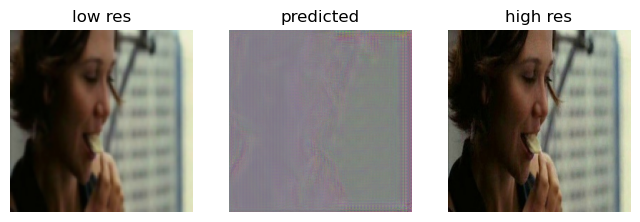

epoch  0 / 5


  0%|          | 0/2908 [00:00<?, ?it/s]

Gen loss:  tensor(0.0048) , Disc loss:  tensor(0.9883)


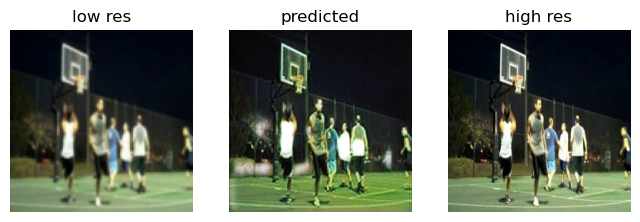

epoch  1 / 5


  0%|          | 0/2908 [00:00<?, ?it/s]

Gen loss:  tensor(0.0102) , Disc loss:  tensor(0.1840)


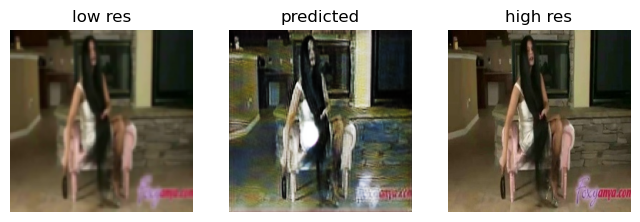

epoch  2 / 5


  0%|          | 0/2908 [00:00<?, ?it/s]

Gen loss:  tensor(0.0091) , Disc loss:  tensor(0.1424)


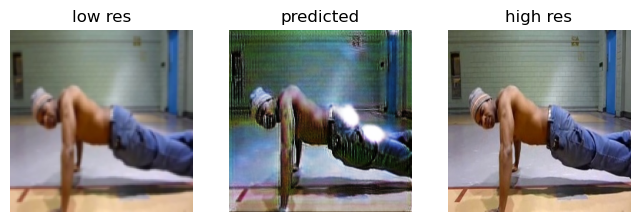

epoch  3 / 5


  0%|          | 0/2908 [00:00<?, ?it/s]

Gen loss:  tensor(0.0087) , Disc loss:  tensor(0.0899)


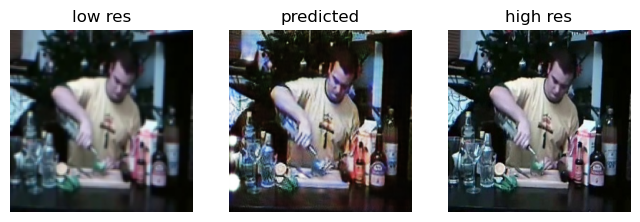

epoch  4 / 5


  0%|          | 0/2908 [00:00<?, ?it/s]

Gen loss:  tensor(0.0095) , Disc loss:  tensor(0.0701)


In [18]:
for epoch in range(epochs):
    plot_examples(gen)
    print("epoch ", i, "/", epochs)
    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
    print('Gen loss: ', gen_loss, ', Disc loss: ', disc_loss)
         # train discriminator and generator and update losses
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)
    i = i + 1
    if i > 12:
        savedir = '/kaggle/working/' + str(i) + '/'
        os.mkdir(savedir)
        torch.save(gen.state_dict(), savedir + "checkpoint1_gen")
        torch.save(disc.state_dict(), savedir + "checkpoint1_disc")

In [19]:
def plot_generated(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
        
            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")
        
            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")
        
            if(idx == 1):
                break
            
    # Show the figure
    plt.show()   

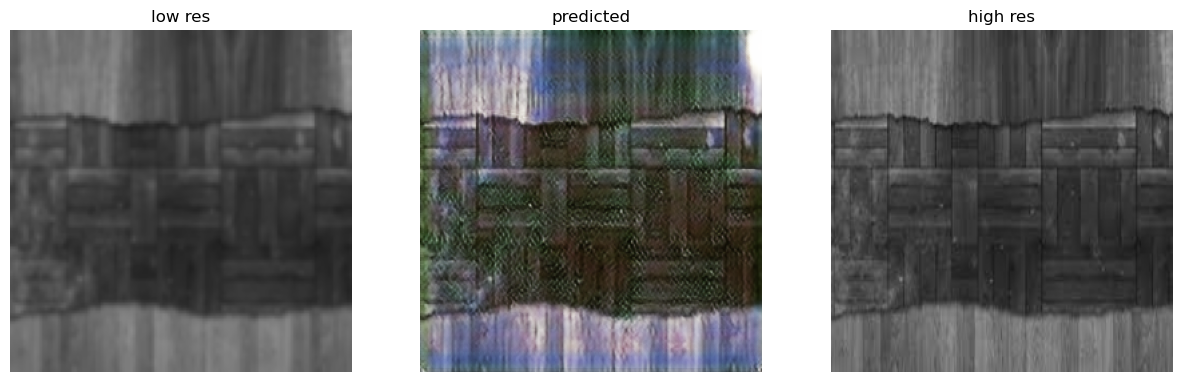

In [20]:
plot_generated(gen)

In [21]:
def train_progress2(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

#     print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

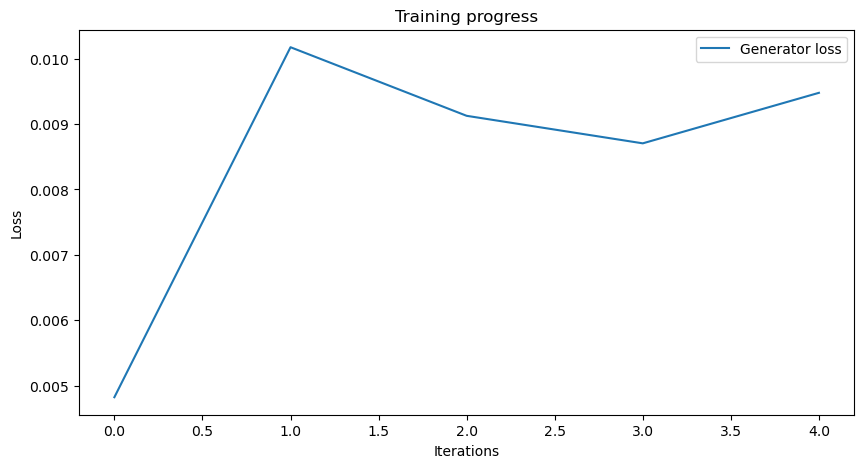

In [22]:
train_progress2(epoch, 5, d_losses, g_losses)

In [23]:
def train_progress3(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss:")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

#     print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

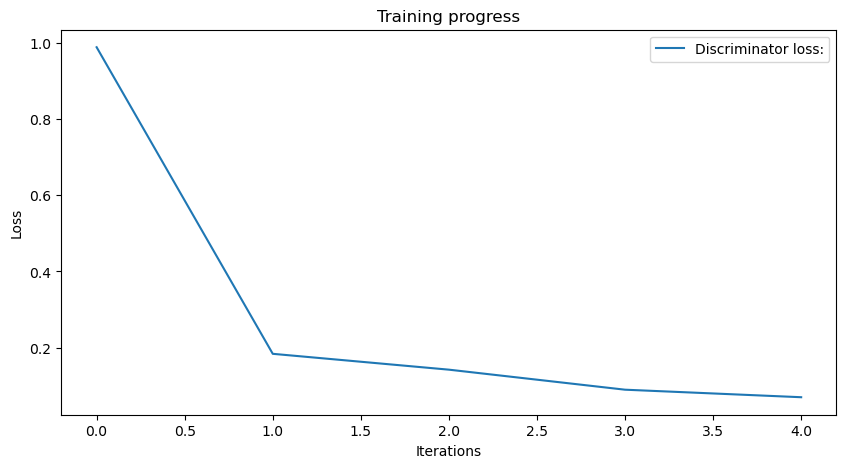

In [24]:
train_progress3(epoch, 5, d_losses, g_losses)

In [38]:
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def get_high_res_and_prediction(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input/test-2/dataset_new/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)
    
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            low_res_img = low_res[chosen].unsqueeze(0).to(device)
            high_res_img = high_res[chosen]
        
            with torch.no_grad():
                upscaled_img = gen(low_res_img)
                upscaled_img = upscaled_img.cpu().squeeze(0)
            
            # Hiển thị 2 ảnh
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(to_pil_image(high_res_img))
            plt.title("High resolution image")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(to_pil_image(upscaled_img))
            plt.title("Upscaled image")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            return high_res_img, upscaled_img

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


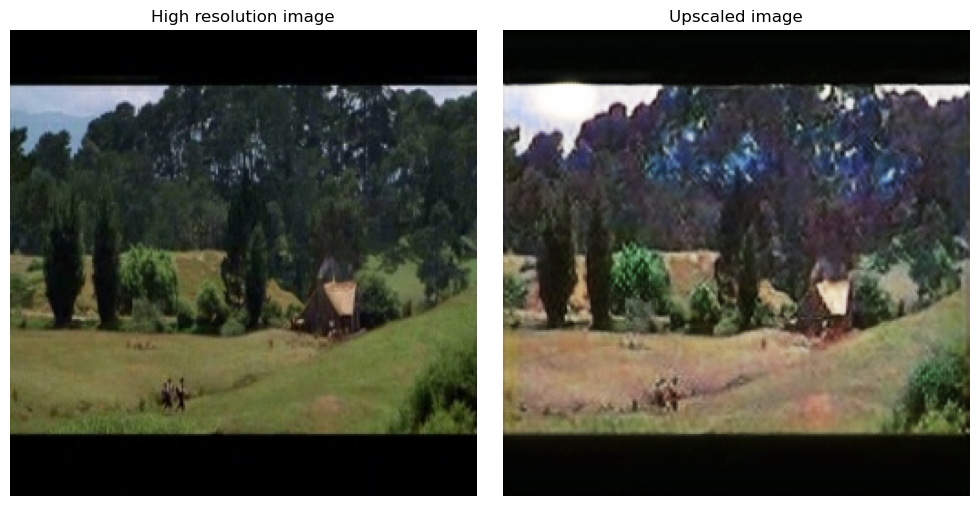

In [39]:
vggL_model = vggL().to(device)
high_res_img, upscaled_img = get_high_res_and_prediction(gen)
high_res_img = high_res_img.unsqueeze(0).to(device)
upscaled_img = upscaled_img.unsqueeze(0).to(device)

In [27]:
loss_function = vggL_model(high_res_img, upscaled_img)
print("Perceptual Loss:", loss_function.item())

Perceptual Loss: 0.40601688623428345


In [28]:
import torch
import torch.nn.functional as F

def calculate_psnr(image1, image2):
    mse = F.mse_loss(image1, image2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

PSNR đo lường tỷ lệ tín hiệu đỉnh so với nhiễu trong ảnh. Giá trị PSNR càng cao (20 - 50 Đối với đơn vị pixel từ 0 đến 255 và  0 - 30 nếu đơn vị pixel được chia tỉ lệ khác nhau, ví dụ như đơn vị từ 0 đến 1) thì chất lượng ảnh càng tốt.

In [29]:
calculate_psnr(high_res_img, upscaled_img)

22.873676300048828

In [30]:
def calculate_ssim(image1, image2):
    ssim = F.mse_loss(image1, image2, reduction='none')
    ssim = (2 * image1 * image2 + 1e-8) / (image1**2 + image2**2 + 1e-8)
    ssim = torch.mean(ssim)
    return ssim.item()

SSIM đo lường sự tương đồng giữa hai ảnh dựa trên độ tương đồng cấu trúc và cường độ. Giá trị SSIM nằm trong khoảng từ -1 đến 1, và càng gần 1 thì ảnh giả càng tương đồng với ảnh thật.

In [31]:
calculate_ssim(high_res_img, upscaled_img)

0.8751563429832458

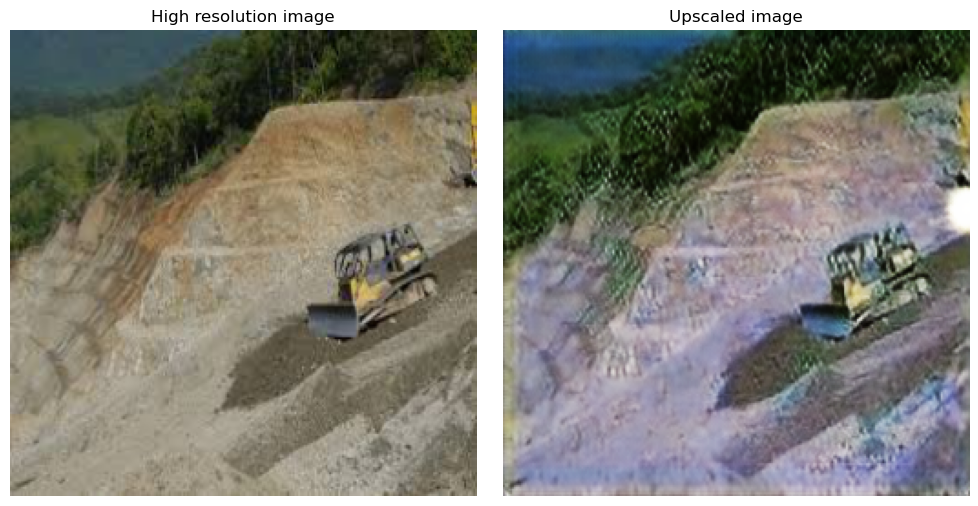

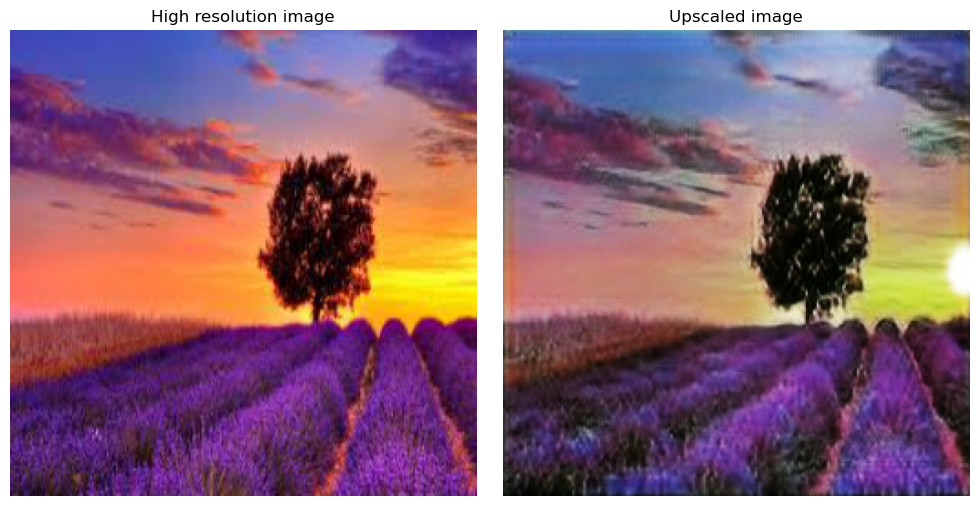

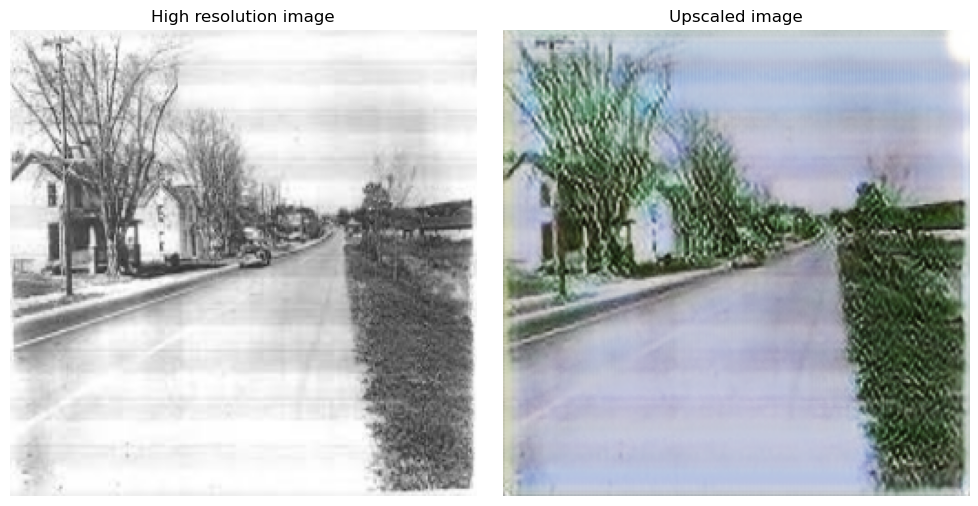

Average PSNR: 18.403963724772137
Average SSIM: 0.9448559085528055


In [32]:
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt

def get_high_res_and_prediction(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)

    total_psnr = 0
    total_ssim = 0
    num_samples = 0

    for idx, (low_res, high_res) in enumerate(loader):
        chosen_batch = random.randint(0, len(loader)-1)
        if chosen_batch != idx:
            continue

        chosen = random.randint(0, len(low_res)-1)

        low_res_img = low_res[chosen].unsqueeze(0).to(device)
        high_res_img = high_res[chosen]

        with torch.no_grad():
            upscaled_img = gen(low_res_img)
            upscaled_img = upscaled_img.cpu().squeeze(0)

        # Tính toán PSNR và SSIM cho cặp ảnh
        psnr = calculate_psnr(high_res_img, upscaled_img)
        ssim = calculate_ssim(high_res_img, upscaled_img)

        # Cộng dồn vào tổng PSNR và SSIM
        total_psnr += psnr
        total_ssim += ssim
        num_samples += 1

        # Hiển thị 2 ảnh
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(to_pil_image(high_res_img))
        plt.title("High resolution image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(to_pil_image(upscaled_img))
        plt.title("Upscaled image")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Tính trung bình PSNR và SSIM cho toàn bộ bộ dữ liệu
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples

    return avg_psnr, avg_ssim

# Gọi hàm để tính trung bình PSNR và SSIM cho bộ dữ liệu
avg_psnr, avg_ssim = get_high_res_and_prediction(gen)
print("Average PSNR:", avg_psnr)
print("Average SSIM:", avg_ssim)

## Cải thiện chất lượng

In [33]:
def upscaledimg(img):
    img = transform_low(img)
    print(img.shape)
    with torch.no_grad():
        upscaled_img = gen(img.to(device).unsqueeze(0))
    print(upscaled_img.shape)
    plt.imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
    return upscaled_img

In [34]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

def with_histogram_matching(img_source):
    upscaled_img = upscaledimg(img_source)
    upscaled_img = torch.reshape(upscaled_img, (3, 256, 256))
    upscaled_img = upscaled_img.cpu().permute(1, 2, 0).numpy()
    
    image = upscaled_img
    reference = img_source/255
    
    matched = match_histograms(image, reference ,
                           channel_axis=-1)


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                        figsize=(10, 10),
                                        sharex=True, sharey=True)

    for aa in (ax1, ax2, ax3):
        aa.set_axis_off()
    reference = cv2.resize(reference, (128, 128))
    reference = cv2.resize(reference, (256, 256))
    
    ax1.imshow(image)
    ax1.set_title('Generated image')
    ax2.imshow(reference)
    ax2.set_title('Low resolution image')
    ax3.imshow(matched)
    ax3.set_title('Matched')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

    for i, img in enumerate((image, reference, matched)):
        for c, c_color in enumerate(('red', 'green', 'blue')):
            img_hist, bins = exposure.histogram(img[..., c],
                                                source_range='dtype')
            axes[c, i].plot(bins, img_hist / img_hist.max())
            img_cdf, bins = exposure.cumulative_distribution(img[..., c])
            axes[c, i].plot(bins, img_cdf)
            axes[c, 0].set_ylabel(c_color)

    axes[0, 0].set_title('Generated image')
    axes[0, 1].set_title('Low resolution image')
    axes[0, 2].set_title('Matched')

    plt.tight_layout()
    plt.show()
    return matched

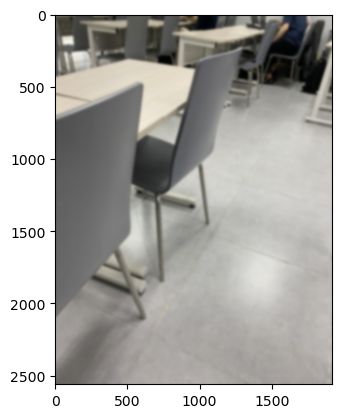

In [35]:
testing = cv2.imread('/kaggle/input/test-3/test_2.jpg')
testing = cv2.cvtColor(testing, cv2.COLOR_BGR2RGB)
plt.imshow(testing)

torch.Size([3, 128, 128])
torch.Size([1, 3, 256, 256])


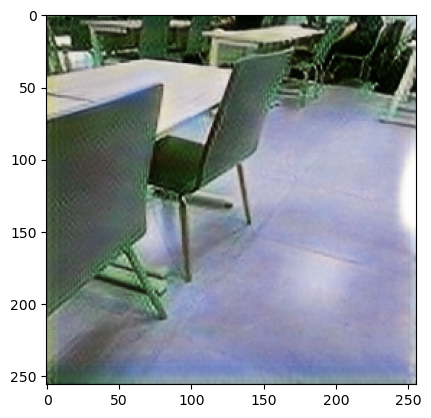

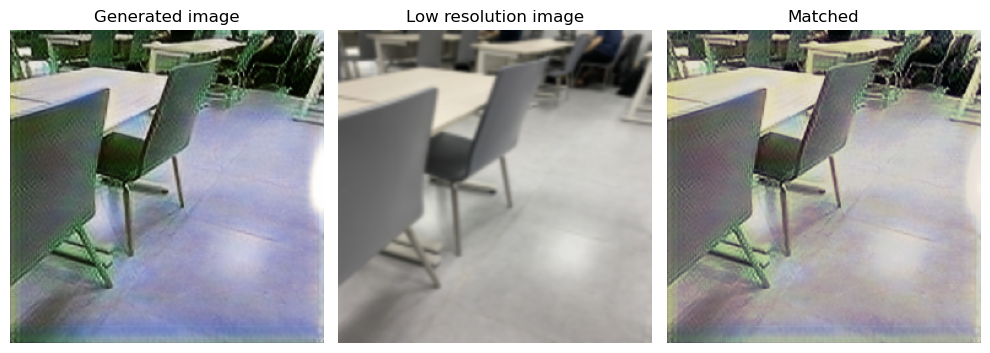

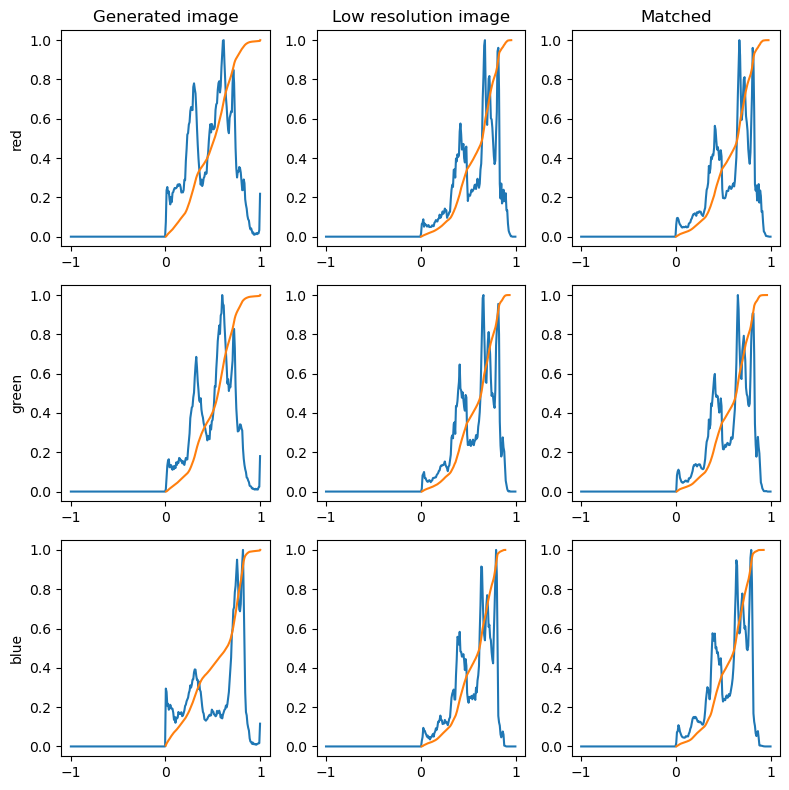

In [36]:
upscaled_with_hmatch = with_histogram_matching(testing)